In [71]:
# Cell 1: imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# sklearn helpers used later
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt


In [72]:
df = pd.read_csv("/content/HR-Employee-Attrition_Dataset.csv")
print('Data loaded:', df)

Data loaded:       Age Attrition     BusinessTravel  DailyRate              Department  \
0      41       Yes      Travel_Rarely       1102                   Sales   
1      49        No  Travel_Frequently        279  Research & Development   
2      37       Yes      Travel_Rarely       1373  Research & Development   
3      33        No  Travel_Frequently       1392  Research & Development   
4      27        No      Travel_Rarely        591  Research & Development   
...   ...       ...                ...        ...                     ...   
1465   36        No  Travel_Frequently        884  Research & Development   
1466   39        No      Travel_Rarely        613  Research & Development   
1467   27        No      Travel_Rarely        155  Research & Development   
1468   49        No  Travel_Frequently       1023                   Sales   
1469   34        No      Travel_Rarely        628  Research & Development   

      DistanceFromHome  Education EducationField  EmployeeCoun

In [73]:
print('Shape:', df.shape)
df.head()

Shape: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [74]:
# Cell 3: Basic structure & sanity checks
print("Columns:", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nBasic stats (numerical):\n", df.describe().T)
print("\nBasic stats (categorical):")
print(df.select_dtypes(include=['object']).nunique().sort_values(ascending=False))

Columns: ['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

Data types:
 Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
Environm

In [75]:
df.isnull().sum()

,0
Age,0
Attrition,0
BusinessTravel,0
DailyRate,0
Department,0
DistanceFromHome,0
Education,0
EducationField,0
EmployeeCount,0
EmployeeNumber,0


In [76]:
df.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
...,...
1465,False
1466,False
1467,False
1468,False


In [77]:
# Cell 4: Missing values and duplicates
missing = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(df) * 100).round(2)
missing_df = pd.concat([missing, missing_percent], axis=1)
missing_df.columns = ['missing_count', 'missing_pct']
print(missing_df[missing_df.missing_count > 0])

Empty DataFrame
Columns: [missing_count, missing_pct]
Index: []


In [78]:
# Cell 5: drop identifiers or irrelevant constant columns
# Common in IBM HR dataset: EmployeeNumber, EmployeeCount, Over18, StandardHours (constants)
to_drop = []
for col in ['EmployeeNumber','EmployeeCount','Over18','StandardHours']:
    if col in df.columns:
        to_drop.append(col)

# Also drop columns with single unique value (no variance)
single_value_cols = [c for c in df.columns if df[c].nunique() == 1]
for c in single_value_cols:
    if c not in to_drop:
        to_drop.append(c)

print('Dropping columns:', to_drop)
df = df.drop(columns=to_drop, errors='ignore')

Dropping columns: ['EmployeeNumber', 'EmployeeCount', 'Over18', 'StandardHours']


In [79]:
# Cell 6: convert object columns -> strip whitespace and lower-case optional
obj_cols = df.select_dtypes(include=['object']).columns.tolist()
for c in obj_cols:
    # strip whitespace (helps with categories like ' Yes' vs 'Yes')
    df[c] = df[c].astype(str).str.strip()

# Convert boolean-like text to category
for c in obj_cols:
    if df[c].nunique() <= 10:  # heuristic: small-cardinality strings likely categorical
        df[c] = df[c].astype('category')

# Convert numeric columns accidentally read as object
# E.g., if MonthlyIncome is object, try coercing
for c in df.columns:
    if df[c].dtype == 'object':
        # try numeric conversion
        coerced = pd.to_numeric(df[c], errors='coerce')
        non_na = coerced.notna().sum()
        if non_na / len(df) > 0.9:
            print(f"Converting {c} -> numeric (coerced NA {coerced.isna().sum()})")
            df[c] = coerced


In [80]:
# Cell 7: check target - assume column 'Attrition'
if 'Attrition' not in df.columns:
    raise ValueError("Target 'Attrition' column not found. Check column names.")

print(df['Attrition'].value_counts(dropna=False))
print('\nPercent:\n', df['Attrition'].value_counts(normalize=True).round(3)*100)


Attrition
No     1233
Yes     237
Name: count, dtype: int64

Percent:
 Attrition
No     83.9
Yes    16.1
Name: proportion, dtype: float64


In [81]:
#outlier detection using IQR, and optional winsorization
def outlier_bounds(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return lower, upper

numeric = df.select_dtypes(include=[np.number]).columns.tolist()
outlier_report = {}
for c in numeric:
    if df[c].nunique() > 10:
        lo, up = outlier_bounds(df[c].dropna())
        outliers = ((df[c] < lo) | (df[c] > up)).sum()
        outlier_report[c] = outliers

# show top columns with outliers
sorted_out = sorted(outlier_report.items(), key=lambda x: x[1], reverse=True)
print('Top outlier counts:', sorted_out[:10])

# Optional: winsorize numeric columns to cap at bounds (demonstration)
df_wins = df.copy()
for c in numeric:
    if df[c].nunique() > 10:
        lo, up = outlier_bounds(df[c])
        df_wins[c] = df_wins[c].clip(lower=lo, upper=up)
# You can choose df = df_wins if you want to keep capped values

Top outlier counts: [('MonthlyIncome', np.int64(114)), ('YearsSinceLastPromotion', np.int64(107)), ('YearsAtCompany', np.int64(104)), ('TotalWorkingYears', np.int64(63)), ('YearsInCurrentRole', np.int64(21)), ('YearsWithCurrManager', np.int64(14)), ('Age', np.int64(0)), ('DailyRate', np.int64(0)), ('DistanceFromHome', np.int64(0)), ('HourlyRate', np.int64(0))]


In [82]:
# Cell 10: encoding (one-hot for small cardinality)
# exclude target
target_col = 'Attrition'
cat_cols = [c for c in df.select_dtypes(include=['category','object']).columns if c != target_col]

# For reproducibility, sort columns to get stable ordering
cat_cols = sorted(cat_cols)
print('Will one-hot encode:', cat_cols)

df_enc = pd.get_dummies(df, columns=cat_cols, drop_first=True)  # drop_first reduces multicollinearity

# Map target to binary
df_enc['AttritionFlag'] = df_enc[target_col].map({'Yes':1, 'No':0})
# drop original target text column
df_enc = df_enc.drop(columns=[target_col])

print('Encoded shape:', df_enc.shape)

Will one-hot encode: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
Encoded shape: (1470, 45)


In [83]:
# Cell 11: feature engineering examples
df2 = df.copy()

# Example: tenure ratio -> YearsAtCompany / TotalWorkingYears (avoid divide by zero)
if 'YearsAtCompany' in df2.columns and 'TotalWorkingYears' in df2.columns:
    df2['tenure_ratio'] = df2['YearsAtCompany'] / (df2['TotalWorkingYears'].replace(0, np.nan))
    df2['tenure_ratio'] = df2['tenure_ratio'].fillna(0)

# Promotion recency flag
if 'YearsSinceLastPromotion' in df2.columns:
    df2['recent_promo'] = (df2['YearsSinceLastPromotion'] <= 1).astype(int)

# High overtime indicator
if 'OverTime' in df2.columns:
    df2['overtime_flag'] = df2['OverTime'].map({'Yes':1, 'No':0})

# Update df_enc if you want to include these new features: merge into df_enc then re-encode if needed
# For demo, we'll merge numeric features into df_enc:
for c in ['tenure_ratio','recent_promo','overtime_flag']:
    if c in df2.columns:
        df_enc[c] = df2[c].values


In [84]:
# Cell 12: Train/test split (stratify by target)
X = df_enc.drop(columns=['AttritionFlag'])
y = df_enc['AttritionFlag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print(
    'Train shape:', X_train.shape, 'Test shape:', X_test.shape
)
print(
    'Train positive rate:', y_train.astype('int').mean(),
    'Test positive rate:', y_test.astype('int').mean()
)

# Save cleaned versions to CSV (for PowerBI or future use)
os.makedirs('cleaned_data', exist_ok=True)
train = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
test = pd.concat([X_test, y_test.reset_index(drop=True)], axis=1)
train.to_csv('cleaned_data/hr_train_cleaned.csv', index=False)
test.to_csv('cleaned_data/hr_test_cleaned.csv', index=False)
print('Saved cleaned CSVs to cleaned_data/')

Train shape: (1176, 47) Test shape: (294, 47)
Train positive rate: 0.16156462585034015 Test positive rate: 0.1598639455782313
Saved cleaned CSVs to cleaned_data/


In [85]:
# Cell 13: scaling numeric features - fit on train only
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
print('Numeric to scale:', numeric_cols[:30])

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Save scaled datasets if you prefer
pd.concat([X_train_scaled, y_train.reset_index(drop=True)], axis=1).to_csv('cleaned_data/hr_train_scaled.csv', index=False)
pd.concat([X_test_scaled, y_test.reset_index(drop=True)], axis=1).to_csv('cleaned_data/hr_test_scaled.csv', index=False)

Numeric to scale: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'tenure_ratio', 'recent_promo']


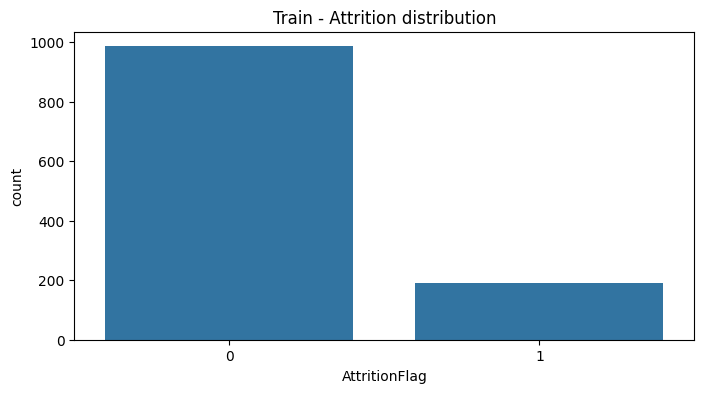

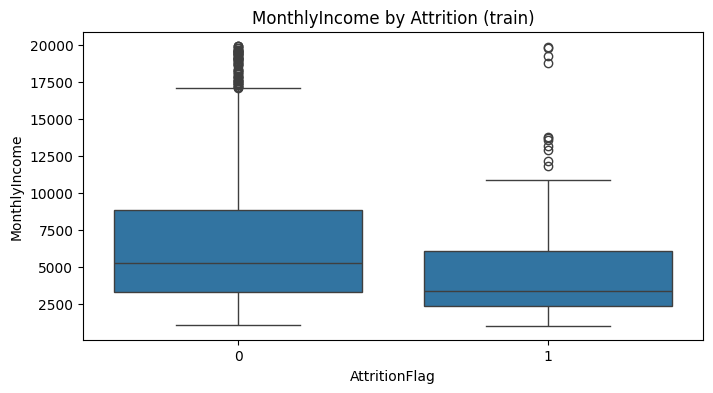

In [86]:
# Cell 15: quick EDA after cleaning
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
sns.countplot(x='AttritionFlag', data=pd.concat([X_train, y_train.reset_index(drop=True)], axis=1))
plt.title('Train - Attrition distribution')
plt.show()

# Example: boxplot monthly income by attrition (if column exists)
if 'MonthlyIncome' in X_train.columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=y_train, y=X_train['MonthlyIncome'])
    plt.title('MonthlyIncome by Attrition (train)')
    plt.show()


✅ Model Accuracy: 83.33%

📊 Classification Report:
              precision    recall  f1-score   support

          No       0.86      0.96      0.91       247
         Yes       0.44      0.17      0.25        47

    accuracy                           0.83       294
   macro avg       0.65      0.56      0.58       294
weighted avg       0.79      0.83      0.80       294



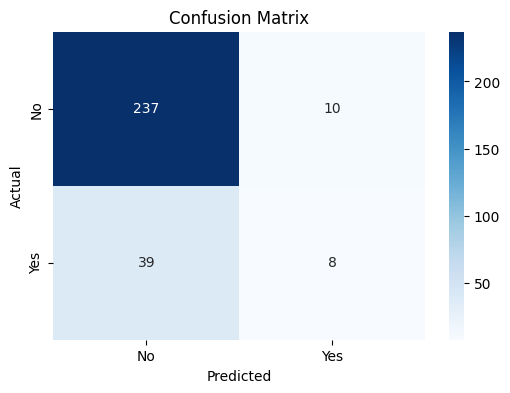

In [87]:

#Define features (X) and target (y)
X = df.drop('Attrition', axis=1)
y = df['Attrition']

#Encode categorical variables
X = pd.get_dummies(X, drop_first=True)

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# --- Option B: Decision Tree ---
model = DecisionTreeClassifier(max_depth=5, random_state=42)

model.fit(X_train, y_train)

#Make predictions
y_pred = model.predict(X_test)

#Model evaluation
acc = accuracy_score(y_test, y_pred)
print(f"✅ Model Accuracy: {acc*100:.2f}%\n")

print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

#Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [88]:
# Save cleaned dataset to a CSV file
df.to_csv('Cleaned_HR_Attrition.csv', index=False)